In [1]:
# base
import sys, os
import numpy as np
import pandas as pd

# image call, utils
import cv2
import tifffile as tiff
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from IPython.display import clear_output

# image preprocess
from skimage import color
from skimage.color import rgb2gray
from skimage.transform import resize

# tts
from sklearn.model_selection import train_test_split as tts

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.callbacks import ModelCheckpoint

# set
tf.config.run_functions_eagerly(True)
sns.set_style('white')
sys.path.append("../")

# data
BASE_PATH = "D:Dataset/dataset/hubmap-organ-segmentation/"
train = pd.read_csv(BASE_PATH+'train_fix_to500.csv')
test = pd.read_csv(BASE_PATH+'test.csv')

# model
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.utils import set_trainable
sm.set_framework('tf.keras')
sm.framework()

# helper function
def mask2rle(mask, orig_dim=160):
    #Rescale image to original size
    size = int(len(mask.flatten())**.5)
    n = Image.fromarray(mask.reshape((size, size))*255.0)
    n = n.resize((orig_dim, orig_dim))
    n = np.array(n).astype(np.float32)
    #Get pixels to flatten
    pixels = n.T.flatten()
    #Round the pixels using the half of the range of pixel value
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    pixels = np.nan_to_num(pixels) #incase of zero-div-error
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, train=False, size=256):
        self.df = df.reset_index(drop=True)
        self.dim = size
        self.train = train
        if self.train: self.batch_size = batch_size // 4
        else: self.batch_size = batch_size
        self.pref = 'train' if train else 'test'
        
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def on_epoch_end(self):
        if self.train: #Reshuffle train on end of epoch
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)
            
    def __getitem__(self, idx):
        batch_x = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].id.values

        if not self.train:
            X = np.zeros((batch_x.shape[0], self.dim, self.dim, 3))
            
            for i in range(batch_x.shape[0]):
                image = Image.open(BASE_PATH+f"train_images_tiles/{batch_x[i]}.png")
                image = image.resize((self.dim, self.dim))
                image = np.array(image) / 255.
                X[i,] = image
                
            return X
                
        else:
            batch_w = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size].img_height.values
            #print(batch_y, batch_w)
            X = np.zeros((batch_x.shape[0]*4, self.dim, self.dim, 3))
            Y = np.zeros((batch_x.shape[0]*4, self.dim, self.dim, 1))
            
            for i in range(batch_x.shape[0]):
                image = Image.open(BASE_PATH+f"train_images_tiles/{batch_x[i]}.png")
                image = image.resize((self.dim, self.dim))
                image = np.array(image) / 255.
                target = Image.open(BASE_PATH+f"masked_images_tiles/{batch_x[i]}.png")
                target = target.resize((self.dim, self.dim))
                target = np.array(target) / 255.
                target = target[:,:,0]
                target = np.expand_dims(target, 2)

                for n, (h, v) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
                    X[i*4 + n, :, :, :] = self.flip_image(image, h, v)[:, :, :]
                    Y[i*4 + n, :, :, :] = self.flip_image(target, h, v)[:, :, :]               
            return X, Y#.reshape(Y.shape[:-1])

    def flip_image(self, image, horizontal=True, vertical=True):
            n_image = image.copy()   
            if horizontal: n_image = n_image[:, ::-1, :]
            if vertical: n_image = n_image[::-1, :, :]
            return n_image
    
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    ce = K.sparse_categorical_crossentropy(y_true, y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * ce
    return K.mean(weighted_ce)

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
        plt.tight_layout()
        plt.show()

# training
def train_organ(organ):
    print("Training for organ:", organ)

    model = Unet('efficientnetb6',input_shape=(image_size, image_size, 3), classes=1, activation='sigmoid', encoder_weights=None)
    model.compile(loss=bce_dice_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy', dice_coef])

    ckp = tf.keras.callbacks.ModelCheckpoint(f"model/to500_{organ}_model.h5", monitor="val_dice_coef",verbose=True, initial_value_threshold=0.3)
    
    X = train[train.organ == organ].reset_index(drop=True)
    train_X, valid_X = tts(X, test_size=0.15, shuffle=True, random_state=2021)
    train_loader = ImageDataGenerator(train_X, batch_size, True, image_size)
    valid_loader = ImageDataGenerator(valid_X, batch_size, True, image_size)

    history = model.fit(train_loader,validation_data=valid_loader,epochs=epochs,use_multiprocessing=False,callbacks=[PlotLearning(), ckp])

    # Model Evaluation and Predidtion
    model = tf.keras.models.load_model(f"model/to500_{organ}_model.h5", compile=False)
    tx, ty = valid_loader[0]
    pty = model.predict(tx).round()

    # Orginal Image VS Mask
    plt.figure(figsize=(20, 20))
    for i in range(4):
        plt.figure(figsize=(20, 20))
        plt.subplot(1, 2, 1)
        plt.title('Orginal')
        plt.imshow(tx[i])
        plt.imshow(ty[i], cmap='coolwarm', alpha=0.5)
        plt.subplot(1, 2, 2)
        plt.title('Predicted')
        plt.imshow(tx[i])
        plt.imshow(pty[i], cmap='coolwarm', alpha=0.5)
        
organs = train.organ.unique()

Segmentation Models: using `keras` framework.


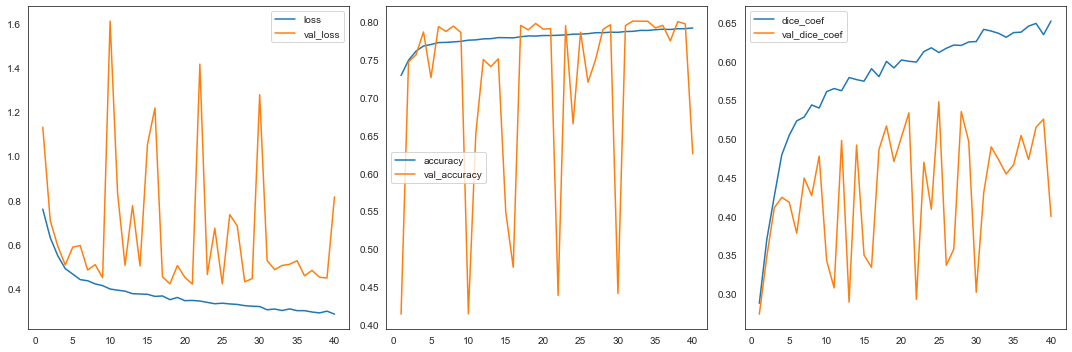


Epoch 40: saving model to model\to500_prostate_model.h5
1/1 [==============================] - 0s 188ms/step
Training Complected for Prostate


<Figure size 1440x1440 with 0 Axes>

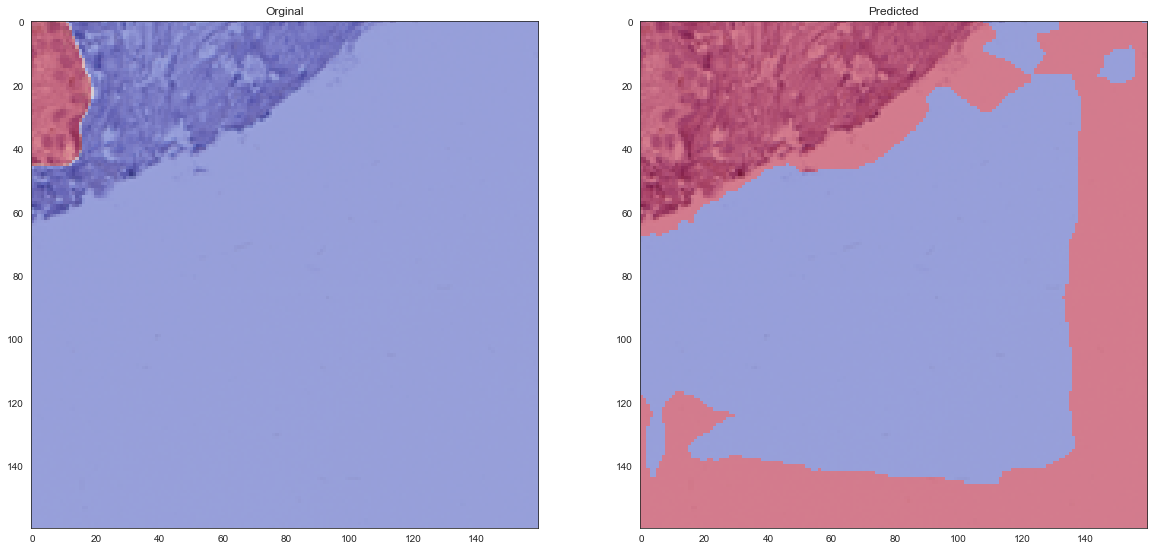

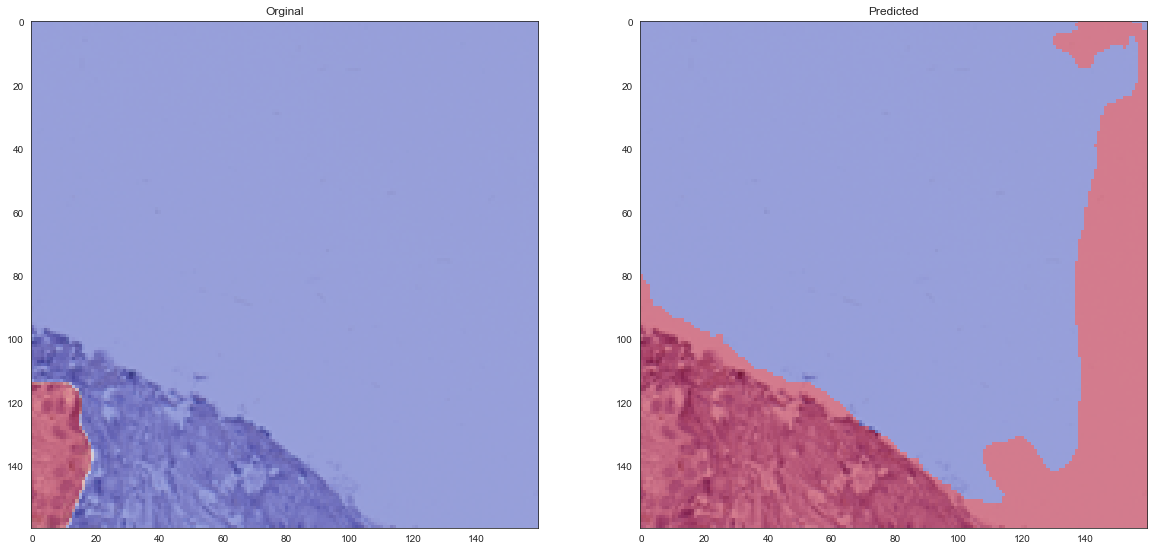

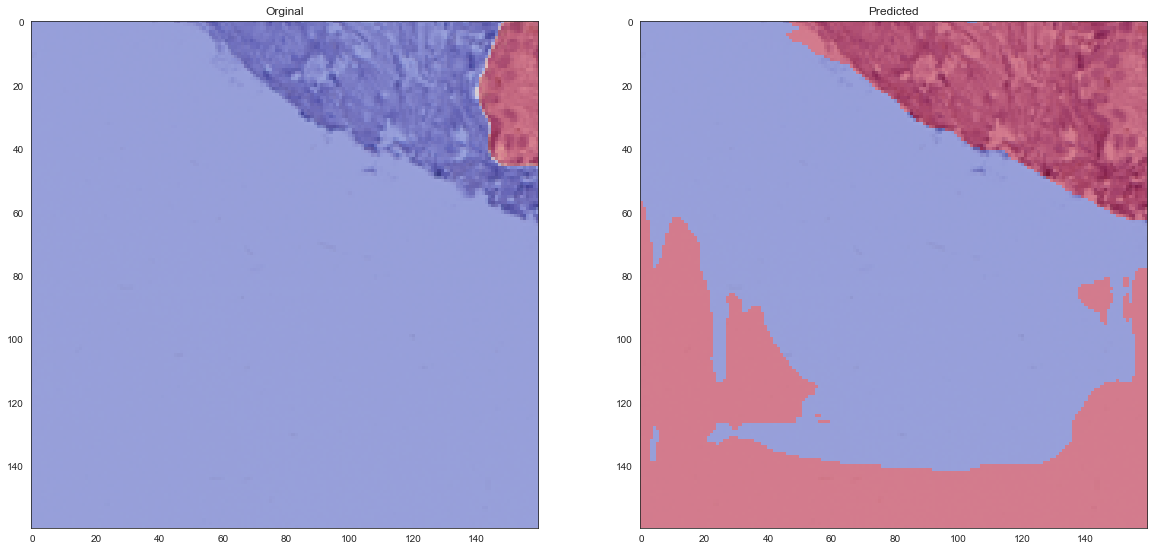

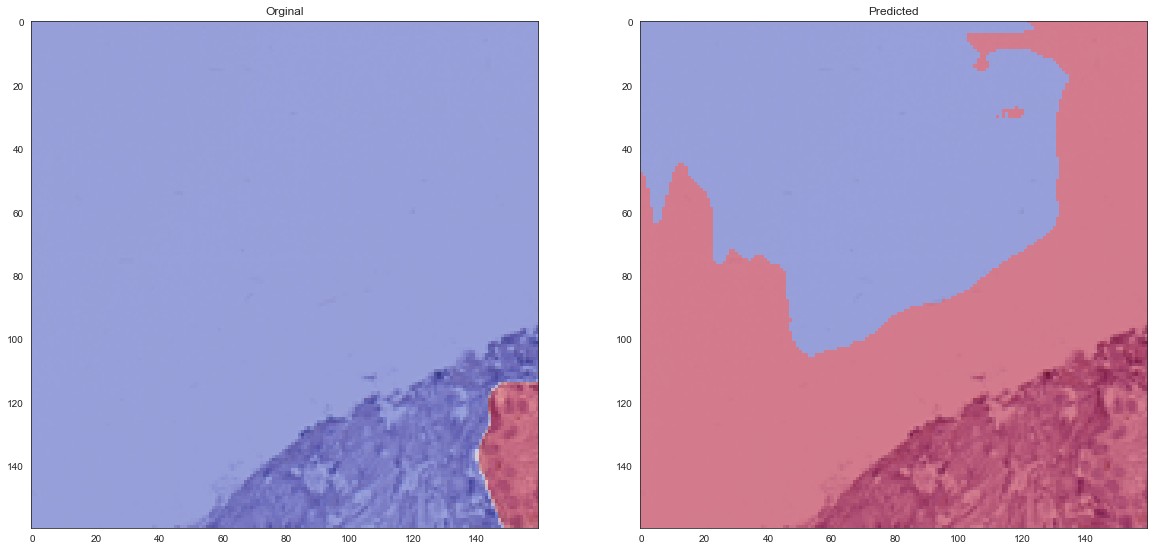

In [2]:
import gc
gc.enable()

epochs = 40
image_size = 160
batch_size = 8
print("Organs:", organs)

train_organ("prostate")
print("Training Complected for Prostate")